<div style="display:fill;
           background-color:#B5CFD8;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/main/smoker_status/smoke-banner.jpg">
    
<H1 style="padding: 20px; color:black; font-weight:600;font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 36px;">PREDICTION OF SMOKER STATUS</H1>
</div>


In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("viridis")
# sns.color_palette("flare")
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

<div style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Table of Contents
    </h1>
</div>

<a href="#1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 1. Dataset Overview </a><br>
<a href="#2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 2. Basic Feature Engineering </a> <br>
<a href="#3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 3. Exploratory Data Analysis & Visualization </a> <br>
<a href="#4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 4. Training Models </a><br>
<a href="#4.1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.1 Baseline XGB Model </a><br>
<a href="#4.2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.2 Baseline LGBM Model </a><br>
<a href="#4.3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.3 Baseline DART Model </a><br>
<a href="#4.4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.4 Optuna Tuned XGB Model </a><br>
<a href="#4.5" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.5 Optuna Tuned LGBM Model  </a><br>
<a href="#4.6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.6 Optuna Tuned DART Model  </a><br>
<a href="#4.7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.7 CatBoost Model  </a><br>
<a href="#4.8" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 16px;padding-left: 25px;"> 4.7 Soft Voting & Stacking  </a><br>
<a href="#6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 5. Feature Importance </a><br>
<a href="#7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 6. Creating 'submission.csv' </a><br>
<a href="#8" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #406882;font-size: 22px;"> 7. Conclusion </a>


<div id="1" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Dataset Overview
    </h1>
</div>

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv",index_col="id")
orig_data = pd.read_csv("/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv",index_col="id")
train_data = pd.concat([train_data,orig_data])

In [3]:
train_data.head(10)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1
5,50,170,55,51.0,1.2,1.2,1,1,146,95,...,31,99,15.9,1,0.7,24,42,119,1,1
6,45,160,55,69.0,1.5,1.2,1,1,150,88,...,69,122,13.0,1,0.7,17,12,16,0,0
7,55,155,60,84.5,0.7,0.9,1,1,137,91,...,51,198,14.5,1,0.7,16,15,16,0,0
8,40,165,70,89.0,0.7,1.0,1,1,130,80,...,59,150,15.7,1,0.9,24,21,31,0,1
9,40,155,50,73.0,1.5,1.5,1,1,105,70,...,55,122,13.2,1,0.7,22,16,14,0,0


In [4]:
test_data.head(10)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
159256,40,165,70,84.0,1.2,1.2,1,1,130,89,...,186,49,115,14.2,1,0.9,19,25,32,0
159257,80,160,60,93.0,1.0,1.0,2,2,144,72,...,158,35,104,13.0,1,1.1,20,12,24,0
159258,60,170,70,86.5,0.6,0.7,1,1,117,75,...,173,39,88,15.4,1,1.4,38,60,36,0
159259,40,160,50,67.0,0.3,0.4,1,1,116,62,...,47,75,128,14.5,1,0.6,25,18,10,1
159260,40,170,75,89.4,1.0,0.9,1,1,132,94,...,100,39,123,16.5,1,1.0,30,39,27,1
159261,40,165,55,75.8,1.0,1.0,1,1,94,52,...,146,41,108,15.1,1,1.0,27,15,56,1
159262,40,165,80,87.0,1.5,1.5,1,1,128,72,...,95,46,160,15.5,1,1.0,24,30,25,0
159263,55,150,50,69.2,1.0,0.9,1,1,152,91,...,89,60,98,14.2,1,0.7,26,20,36,0
159264,70,160,60,79.0,0.5,0.5,1,1,150,90,...,116,57,113,13.9,1,1.2,19,24,18,0


<div id="2" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Basic Feature Engineering
    </h1>
</div>

In [5]:
train_data["BMI"] = train_data["weight(kg)"] / (train_data["height(cm)"]/100)**2
train_data["HDL-LDL Ratio"] = train_data["HDL"] / train_data["LDL"]
train_data["HDL-triglyceride Ratio"] = train_data["HDL"] / train_data["triglyceride"]
train_data["LDL-triglyceride Ratio"] = train_data["LDL"] / train_data["triglyceride"]
# train_data["HDL-Cholesterol Ratio"] = train_data["HDL"] / train_data["Cholesterol"]
# train_data["LDL-Cholesterol Ratio"] = train_data["LDL"] / train_data["Cholesterol"]
train_data["Liver Enzyme Ratio"] = train_data["AST"] / train_data["ALT"]

In [6]:
test_data["BMI"] = test_data["weight(kg)"] / (test_data["height(cm)"]/100)**2
test_data["HDL-LDL Ratio"] = test_data["HDL"] / test_data["LDL"]
test_data["HDL-triglyceride Ratio"] = test_data["HDL"] / test_data["triglyceride"]
test_data["LDL-triglyceride Ratio"] = test_data["LDL"] / test_data["triglyceride"]
# test_data["HDL-Cholesterol Ratio"] = test_data["HDL"] / test_data["Cholesterol"]
# test_data["LDL-Cholesterol Ratio"] = test_data["LDL"] / test_data["Cholesterol"]
test_data["Liver Enzyme Ratio"] = test_data["AST"] / test_data["ALT"]

In [7]:
train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,AST,ALT,Gtp,dental caries,smoking,BMI,HDL-LDL Ratio,HDL-triglyceride Ratio,LDL-triglyceride Ratio,Liver Enzyme Ratio
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,22,25,27,0,1,22.038567,0.533333,0.133333,0.250000,0.880000
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,27,23,37,1,0,23.875115,0.452381,1.036364,2.290909,1.173913
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,27,31,53,0,1,25.951557,0.483871,0.228426,0.472081,0.870968
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,20,27,30,1,0,29.320988,0.372549,0.187192,0.502463,0.740741
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,19,13,17,0,1,22.038567,0.473118,0.505747,1.068966,1.461538


<div id="3" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Exploratory Data Analysis & Visualization
    </h1>
</div>

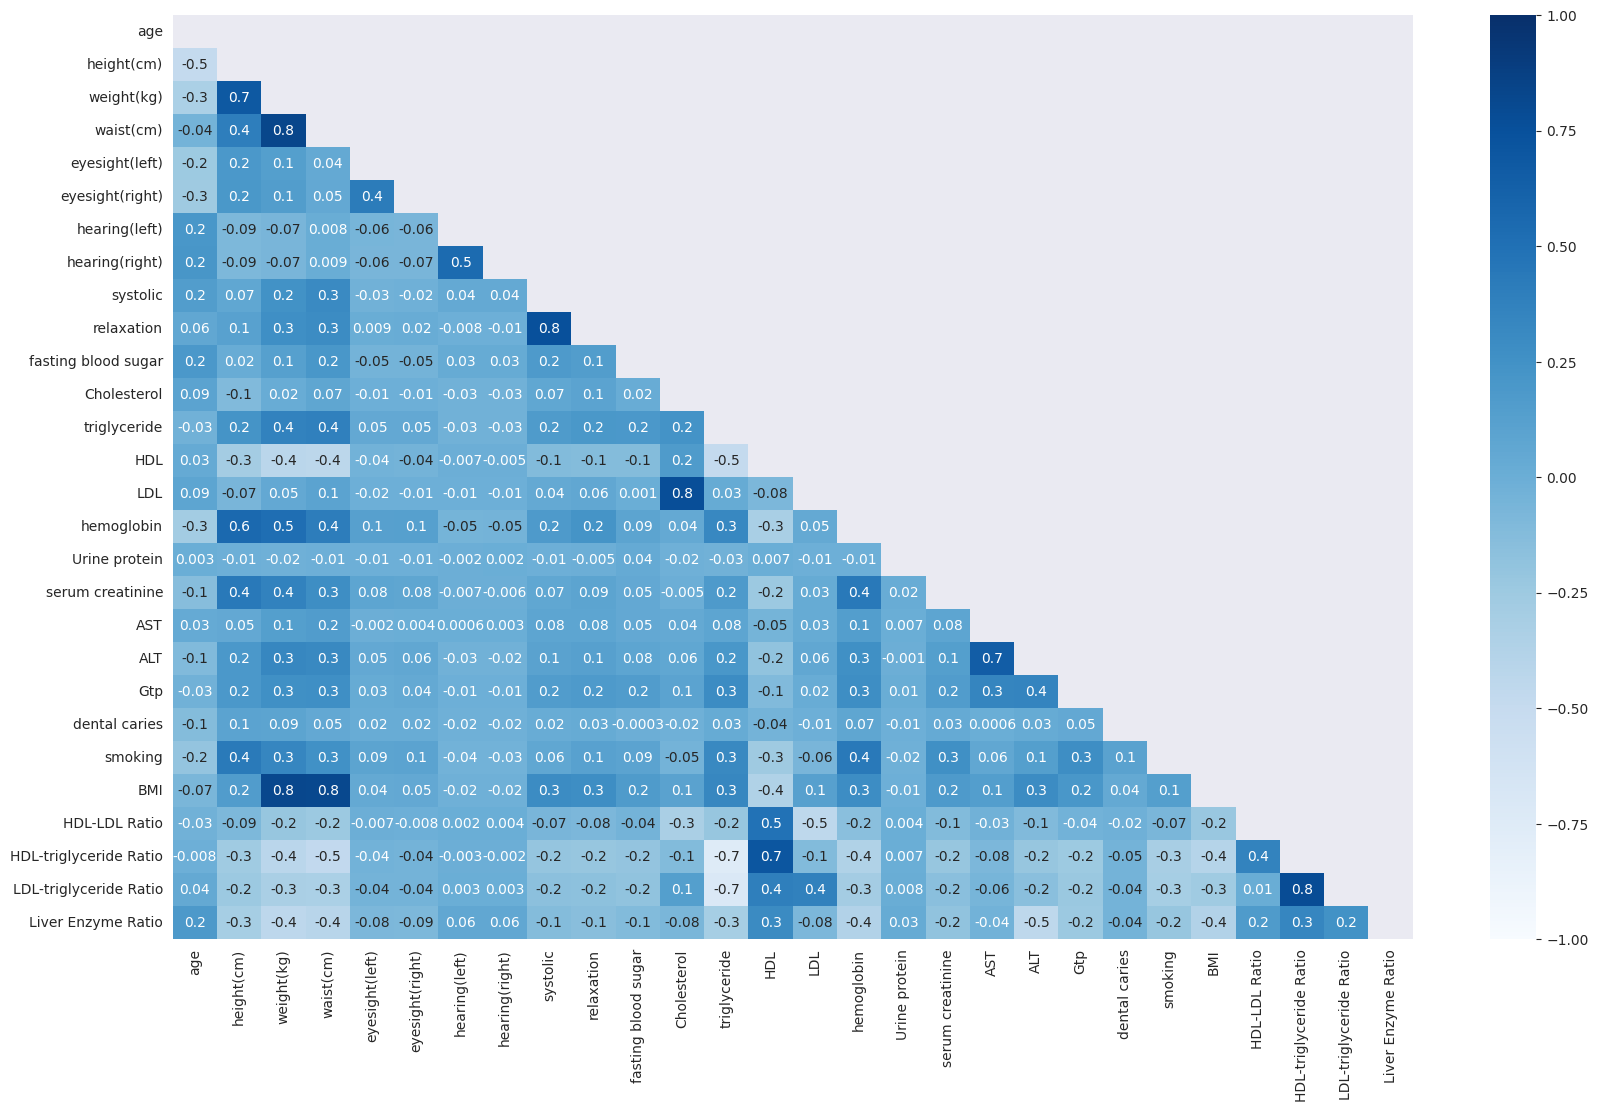

In [8]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(train_data.corr(), cmap="Blues", annot=True, mask=mask,vmin=-1,vmax=1,fmt=".1g");

In [9]:
fig,axes = plt.subplots(23,2,figsize=(15, 60),dpi=300)

for ind,col in enumerate(orig_data.columns):
    if train_data[col].nunique()!=2:
        plt.subplot(23,2,2*ind+1)
        sns.histplot(orig_data[col],bins=15,kde=True)
        plt.gca().set_title(col)
    elif col!="smoking":
        plt.subplot(23,2,2*ind+1)
        sns.countplot(data = orig_data,x=col,hue="smoking")
        plt.gca().set_title(col)
    else:
        plt.subplot(23,2,2*ind+1)
        sns.countplot(data = orig_data,x=col)
        plt.gca().set_title(col)
    
    if train_data[col].nunique()!=2:
        plt.subplot(23,2,2*ind+2)
        sns.boxplot(orig_data[col],orient="h",palette="Blues")
        plt.gca().set_title(col)
    else:
        plt.subplot(23,2,2*ind+2)
        sns.histplot(binwidth=0.5, x="dental caries", hue="smoking", data=orig_data, stat="count", multiple="stack",palette="Blues")
        plt.gca().set_title(col)

fig.tight_layout()
plt.show()

<div id="4" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
   Training Models
    </h1>
</div>

In [10]:
seed = np.random.seed(6)

X = train_data.drop(["smoking"],axis=1)
y = train_data["smoking"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=seed)

<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.1 Baseline XGB Model
    </h1>
</div>
<hr>

In [11]:
xgbmodel = XGBClassifier(random_state=seed, tree_method= 'gpu_hist')
print("CV score of XGB is ",cross_val_score(xgbmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of XGB is  0.8612085174356495


<div id="4.2" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.2 Baseline LGBM Model
    </h1>
</div>
<hr>

In [12]:
lgbmmodel = LGBMClassifier(random_state=seed, device="gpu")
print("CV score of LGBM is ",cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of LGBM is  0.8606738815936545


<div id="4.3" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.3 Baseline DART Model
    </h1>
</div>
<hr>

In [13]:
dartmodel = LGBMClassifier(random_state = seed, device="gpu", boosting_type = 'dart')
print("CV score of DART is ",cross_val_score(dartmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of DART is  0.8558066227773931


<div id="4.4" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.4 Optuna Tuning XGB
    </h1>
</div>
<hr>

In [14]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',500,750),
#         'max_depth':  trial.suggest_int('max_depth',3,50),
#         'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
#         'subsample': trial.suggest_float('subsample', 0.2, 1),
#         'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
#         "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
#     }
#     xgbmodel_optuna = XGBClassifier(**params,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
#     cv = cross_val_score(xgbmodel_optuna, X, y, cv = 4,scoring='roc_auc').mean()
#     return cv

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100,timeout=5000)

In [15]:
# CV: 0.8685616459613721
xgb_params =   {'n_estimators': 727, 'max_depth': 44, 'min_child_weight': 42.394074475465935,
                'learning_rate': 0.018945904767046495, 'subsample': 0.9976305222111156,
                'gamma': 0.23054785929528437, 'colsample_bytree': 0.4156956766282452,
                'colsample_bylevel': 0.9225226228188033, 'colsample_bynode': 0.686558727709571}

xgb_opt = XGBClassifier(**xgb_params,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
xgb_opt.fit(X_train,y_train)
print("CV score of XGB Optuna is ",cross_val_score(xgb_opt,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of XGB Optuna is  0.8685616459613721


<div id="4.5" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.5 Optuna Tuning LGBM
    </h1>
</div>
<hr>

In [16]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',500,2500),
#         "max_depth":trial.suggest_int('max_depth',3,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
#         "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
#         "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
#         "subsample" : trial.suggest_float('subsample', 0.2, 1),
#         "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
#     }
#     lgbmmodel_optuna = LGBMClassifier(**params,random_state=seed,device="gpu")
#     cv = cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='roc_auc').mean()
#     return cv

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100,timeout=2000)

In [17]:
# 0.8686512553111709
lgbm_params = {'n_estimators': 624, 'max_depth': 46, 'learning_rate': 0.06953273561619135,
               'min_child_weight': 2.4187716216112944, 'min_child_samples': 230, 'subsample': 0.9515130309407626,
               'subsample_freq': 4, 'colsample_bytree': 0.402284262124352, 'num_leaves': 71}

lgbm_opt = LGBMClassifier(**lgbm_params,random_state=seed,device="gpu")
lgbm_opt.fit(X_train,y_train)
print("CV score of LGBM Optuna is ",cross_val_score(lgbm_opt,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of LGBM Optuna is  0.868668129802976


<div id="4.6" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.6 Optuna Tuning DART
    </h1>
</div>
<hr>

In [18]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',750,1000),
#         "max_depth":trial.suggest_int('max_depth',3,75),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
#         "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,10),
#         "min_child_samples" : trial.suggest_int('min_child_samples',1,50),
#         "subsample" : trial.suggest_float('subsample', 0.2, 1),
#         "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#     }
#     lgbmmodel_optuna = LGBMClassifier(**params,random_state=seed,device="gpu",boosting_type = 'dart')
#     cv = cross_val_score(lgbmmodel_optuna, X, y, cv = 3,scoring='roc_auc').mean()
#     return cv

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100,timeout=10000)

In [19]:
# 0.8660506011161845
dart_params = {'n_estimators': 1491, 'max_depth': 58, 'learning_rate': 0.1649865134687319,
               'min_child_weight': 6.142064466461694, 'min_child_samples': 21,
               'subsample': 0.8859466796010151, 'subsample_freq': 4, 'colsample_bytree': 0.4812664823962418}

dart_opt = LGBMClassifier(**dart_params,random_state=seed,device="gpu",boosting_type = 'dart')
dart_opt.fit(X_train,y_train)
print("CV score of DART Optuna is ",cross_val_score(dart_opt,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of DART Optuna is  0.8661059399138115


<div id="4.7" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.7 CatBoost Classifier
    </h1>
</div>
<hr>

In [20]:
catmodel = CatBoostClassifier(iterations=1250,verbose=250, random_seed=seed)
catmodel.fit(X,y)
print("CV score of CatBoost is ",cross_val_score(catmodel,X,y,cv=4, scoring = 'roc_auc').mean())

Learning rate set to 0.080347
0:	learn: 0.6541968	total: 92.3ms	remaining: 1m 55s
250:	learn: 0.4415401	total: 7.93s	remaining: 31.6s
500:	learn: 0.4298300	total: 16s	remaining: 24s
750:	learn: 0.4204473	total: 23.7s	remaining: 15.7s
1000:	learn: 0.4119827	total: 31.3s	remaining: 7.79s
1249:	learn: 0.4042537	total: 39s	remaining: 0us
Learning rate set to 0.071059
0:	learn: 0.6600860	total: 33.6ms	remaining: 41.9s
250:	learn: 0.4431891	total: 6.71s	remaining: 26.7s
500:	learn: 0.4302092	total: 12.7s	remaining: 19s
750:	learn: 0.4197477	total: 18.7s	remaining: 12.5s
1000:	learn: 0.4101231	total: 24.8s	remaining: 6.17s
1249:	learn: 0.4013340	total: 31s	remaining: 0us
Learning rate set to 0.071059
0:	learn: 0.6595072	total: 28ms	remaining: 35s
250:	learn: 0.4431440	total: 6.63s	remaining: 26.4s
500:	learn: 0.4300942	total: 12.7s	remaining: 19s
750:	learn: 0.4193254	total: 18.7s	remaining: 12.4s
1000:	learn: 0.4096469	total: 24.8s	remaining: 6.17s
1249:	learn: 0.4007116	total: 31s	remaining

<div id="4.8" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.8 Soft Voting and Stacking XGB + LGBM + CAT + DART
    </h1>
</div>
<hr>

In [21]:
vcmodel = VotingClassifier([("lgbm",lgbm_opt),("xgb",xgb_opt),("cat",catmodel),("dart",dart_opt)],voting="soft",weights=[4,3,2,1])
print("CV score of VC is ",cross_val_score(vcmodel,X,y,cv=4, scoring = 'roc_auc').mean())

Learning rate set to 0.071059
0:	learn: 0.6600860	total: 27.7ms	remaining: 34.6s
250:	learn: 0.4431891	total: 6.26s	remaining: 24.9s
500:	learn: 0.4302092	total: 12.3s	remaining: 18.4s
750:	learn: 0.4197477	total: 18.3s	remaining: 12.2s
1000:	learn: 0.4101231	total: 24.5s	remaining: 6.09s
1249:	learn: 0.4013340	total: 31s	remaining: 0us
Learning rate set to 0.071059
0:	learn: 0.6595072	total: 29.7ms	remaining: 37.1s
250:	learn: 0.4431440	total: 6.73s	remaining: 26.8s
500:	learn: 0.4300942	total: 12.7s	remaining: 18.9s
750:	learn: 0.4193254	total: 18.7s	remaining: 12.5s
1000:	learn: 0.4096469	total: 24.9s	remaining: 6.2s
1249:	learn: 0.4007116	total: 31s	remaining: 0us
Learning rate set to 0.071059
0:	learn: 0.6595117	total: 29.2ms	remaining: 36.5s
250:	learn: 0.4448646	total: 6.34s	remaining: 25.2s
500:	learn: 0.4324001	total: 12.3s	remaining: 18.4s
750:	learn: 0.4215354	total: 18.3s	remaining: 12.2s
1000:	learn: 0.4118370	total: 24.4s	remaining: 6.07s
1249:	learn: 0.4029571	total: 30.

In [22]:
scmodel = StackingClassifier(estimators=[("lgbm",lgbm_opt),("xgb",xgb_opt)])
print("CV score of SC is ",cross_val_score(scmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of SC is  0.8696301863285202


<div id="6" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
   Plotting Feature Importance
    </h1>
</div>

In [23]:
history = pd.DataFrame()
def plotImportance(modelName,model):
    history["cols"] = X_test.columns
    history["imp"] = model.feature_importances_
    history.sort_values("imp",inplace=True,ascending=False)
    history.reset_index(drop=True)
    plt.figure(figsize=(15,7))
    sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
    plt.title("Feature Imporance of "+modelName)

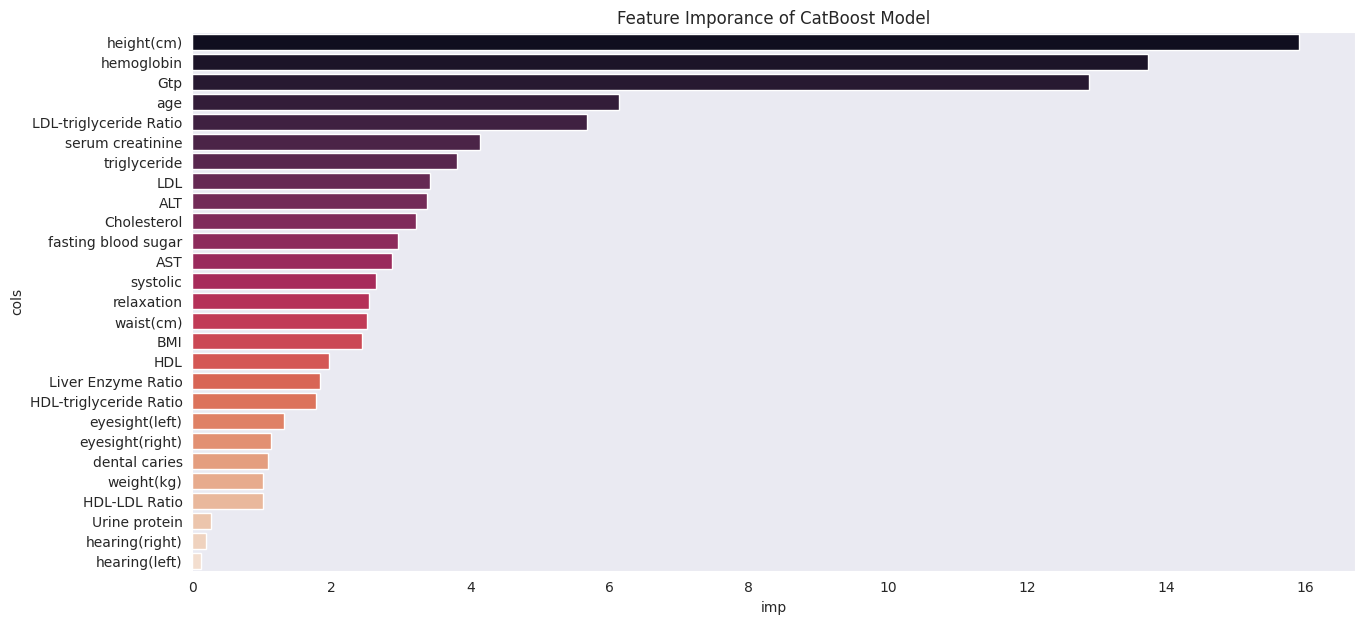

In [24]:
plotImportance("CatBoost Model",catmodel)

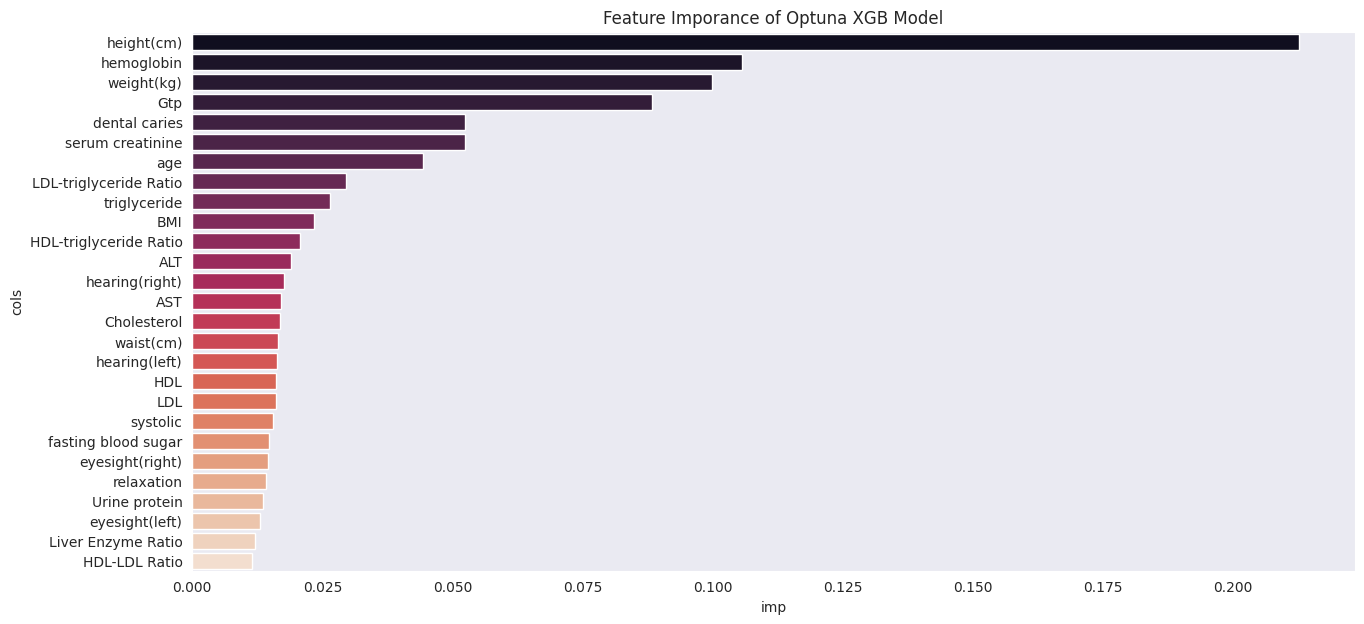

In [25]:
plotImportance("Optuna XGB Model",xgb_opt)

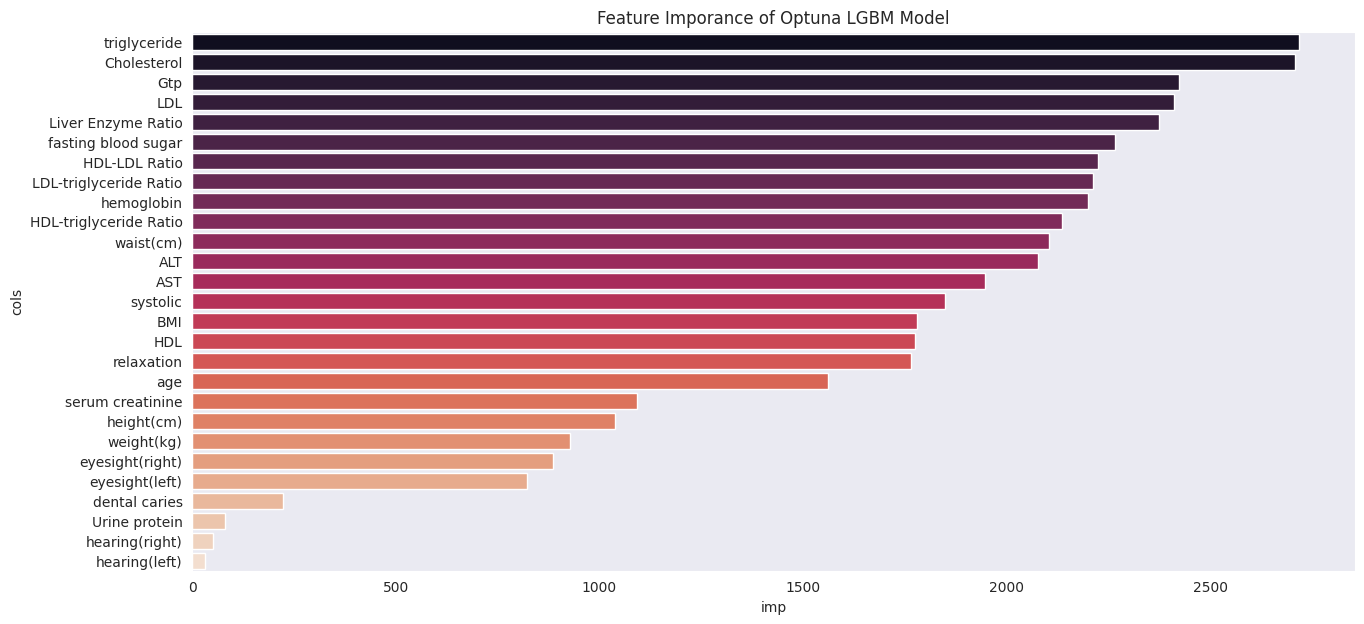

In [26]:
plotImportance("Optuna LGBM Model",lgbm_opt)

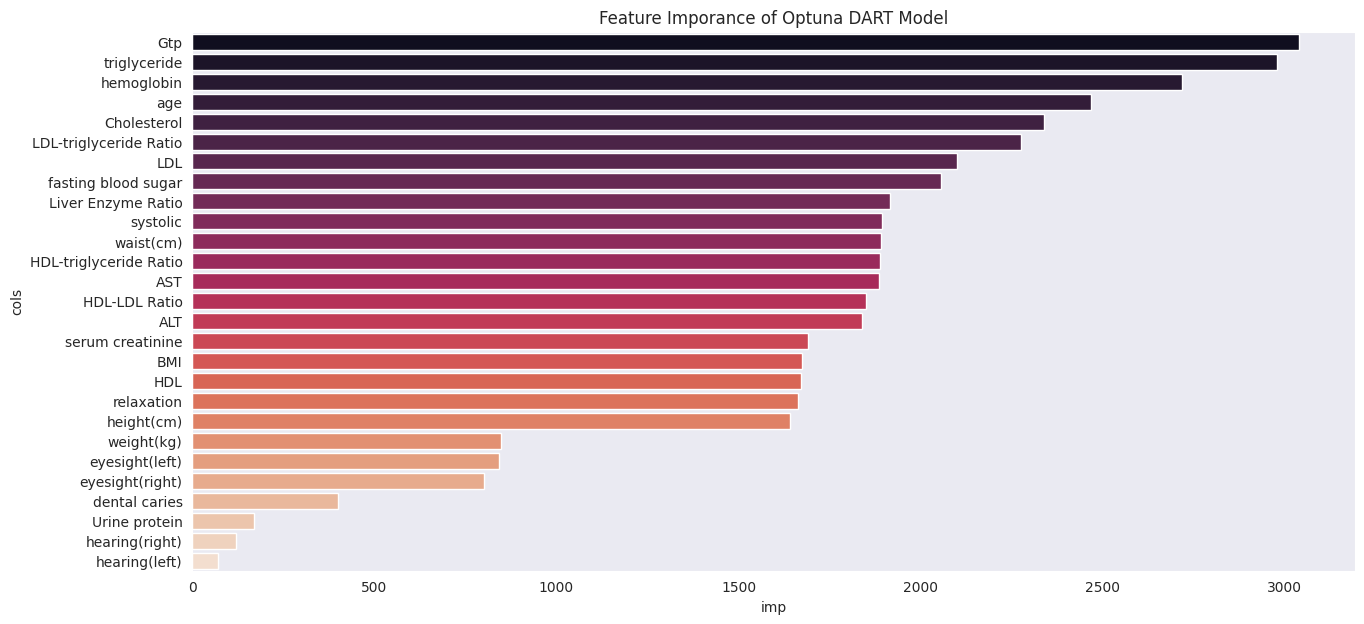

In [27]:
plotImportance("Optuna DART Model",dart_opt)

<div id="7" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
   Creating 'submission.csv'
    </h1>
</div>

In [28]:
vcmodel.fit(X,y)
scmodel.fit(X,y)

predsVC = vcmodel.predict_proba(test_data)[:,1]
predsSC = scmodel.predict_proba(test_data)[:,1]

submission = pd.DataFrame()
submission["id"] = test_data.index
submission["smoking"] = (0.7*predsVC+0.3*predsSC)
submission.to_csv("submission.csv",header=True,index=False)

Learning rate set to 0.080347
0:	learn: 0.6541968	total: 37.6ms	remaining: 47s
250:	learn: 0.4415401	total: 8.26s	remaining: 32.9s
500:	learn: 0.4298300	total: 16.3s	remaining: 24.3s
750:	learn: 0.4204473	total: 24s	remaining: 15.9s
1000:	learn: 0.4119827	total: 31.8s	remaining: 7.91s
1249:	learn: 0.4042537	total: 40s	remaining: 0us


In [29]:
submission.head(10)

,id,smoking
0,159256,0.648003
1,159257,0.258339
2,159258,0.346749
3,159259,0.027488
4,159260,0.578297
5,159261,0.928504
6,159262,0.508937
7,159263,0.053153
8,159264,0.135403
9,159265,0.032879


<div id = "8" style="background-color: #B5CFD8; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Conclusion
    <h3 style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: center; color: #406882; line-height: 1.6;">
    If you found the notebook helpful, please Upvote the Notebook😊<br>
    If you have any suggestion, feel free to Comment & Tag me<br>
        <br>
    You can explore my another approach to this problem:<br> <a href="https://www.kaggle.com/code/iqmansingh/smoker-status-oof-preds-lgbm-catboost-xgb?scriptVersionId=148330027" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: center; color: #406882; line-height: 1.6;text-decoration: underline;;">🚬🚬 Smoker Status | ⚡ OOF Preds LGBM+CatBoost+XGB</a>
    </h3>
</div>

